#  Bibliotecas

In [37]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.linear_model import LinearRegression

# Common imports
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

## Funções 

In [38]:
# Para gráficos e figuras:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "primeira_parte"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# para importar dados:  
DATASET_PATH = os.path.join("datasets")

def load_mackeyglass_data(dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, "mackeyglass.csv")
    return pd.read_csv(csv_path)

# Para separar conjuntos de treinamento:
def split_train_test(data, test_ratio): # separa dados de teste (mais recentes) e de treinamento
    test_set_size = int(len(data) * test_ratio) # define tamanho do conjunto de teste
    train_set_size = len(data) - test_set_size # calcula tamanho do conjunto de treinamento
    return data.iloc[:train_set_size], data.iloc[train_set_size:] # retorna conjunto de treinamento e de dados, respectivamente

# Primeira Parte: Sistema de Mackey-Glass

In [39]:
# to make this notebook's output stable across runs
np.random.seed(42)

### Importando e interpretando os dados

In [40]:
mackeyglass = load_mackeyglass_data()
mackeyglass.head()

,t,p
0,0.0,0.188921
1,1.0,0.190910
2,2.0,0.194433
3,3.0,0.199178
4,4.0,0.204882


In [41]:
mackeyglass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       5000 non-null   float64
 1   p       5000 non-null   float64
dtypes: float64(2)
memory usage: 78.2 KB


Saving figure mackeyglass


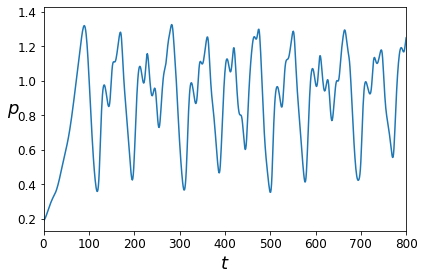

In [42]:
t = mackeyglass['t'].to_numpy()
p = mackeyglass['p'].to_numpy()

plt.plot(t, p)
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$p$", rotation=0, fontsize=18)
plt.xlim(0,800)
save_fig("mackeyglass")
plt.show()

### Conjunto de teste

In [43]:
train_set, test_set = split_train_test(mackeyglass, .15)
train_set

,t,p
0,0.0,0.188921
1,1.0,0.190910
2,2.0,0.194433
3,3.0,0.199178
4,4.0,0.204882
...,...,...
4245,4245.0,1.131059
4246,4246.0,1.110181
4247,4247.0,1.085578
4248,4248.0,1.059587


### Conjunto de Validação

In [44]:
train_set, validation_set = split_train_test(train_set, .2)

### Montagem das matrizes 

In [45]:
L = 7 # horizonte de predição

In [62]:
def monta_matrizes(dataset, K, L=L):            
    t = dataset['t'].to_numpy()  
    p = dataset['p'].to_numpy()
    y_size = len(dataset) - (L+K-1) # número de linhas da matriz y
    y = p[(L+K-1):] # matriz y: valores de p[L+K-1:(end)]
    x = np.array([np.append(np.array([1]),p[0:K])]) # cria primeira linha da matrix x 
    x = np.flip(x,1) # espelha primeira linha da matriz
    for i in np.arange(1, y_size, 1):    # cria uma linha nova de x a cada iteração (y_size iterações)
        c_aux = [np.append(np.array([1]),p[i:K+i])]  # cria a coluna de p[i] até p[K+i-1]
        c = np.flip(c_aux,1)   # espelha a linha
        x = np.concatenate((x, c)) # adiciona linha à matriz 
    t_y = t[(L+K-1):] # valores de t das saídas y(t)
    return t_y, x, y
    
def new_matrices(K, new_set, dataset=mackeyglass, L=L):
    t = dataset['t'].to_numpy() # separa t e p do dataset original (mackeyglass)
    p = dataset['p'].to_numpy()
    t_new = new_set['t'].to_numpy() # separa colunas 't' e 'p' do conjunto de validação
    y_new = new_set['p'].to_numpy()
    x_new = np.array([np.append(np.array([1]),p[int(t_new[0])-L-K:int(t_new[0])-L])]) # cria primeira linha da matrix x 
    x_new = np.flip(x_new,1) # espelha primeira linha da matriz    
    for i in np.arange(1, len(y_new), 1):    # cria uma linha nova de x a cada iteração 
        c_aux = [np.append(np.array([1]),p[int(t_new[0])-L+i-K:int(t_new[0])-L+i])]  # cria nova coluna
        c = np.flip(c_aux,1)  # espelha a linha
        x_new = np.concatenate((x_new, c)) # adiciona linha à matriz
    return t_new, x_new, y_new

## Regressão Linear

In [47]:
lin_reg = LinearRegression()

### Erro quadrático médio (RMSE)

In [63]:
def rmse(y, y_predict):  # calcula erro quadrático médio
    e = y - y_predict # erro entre estimado e real
    rmse = np.sqrt(sum(e**2)/len(e)) # erro quadrático médio
    return rmse

#np.sqrt(sklearn.metrics.mean_squared_error(y, y_predict)) # rmse pelo scikit learn

## Validação Cruzada

In [64]:
rmse_matrix = [] # RMSE para cada valor de K na validação 
rmse_matrix_train = [] # RMSE para cada valor de K no treinamento

K_max = 50

for K in np.arange(1,K_max+1,1): # realiza a regressão linear para K = 1 a 50 e calcula o RMSE para os conjuntos de treinamento e de teste
    t_y, x, y = monta_matrizes(train_set, K) # monta matrizes para treinamento
    lin_reg.fit(x, y) # fit com matrizes de treinamento
    t_val, x_val, y_val = new_matrices(K, validation_set) # monta matrizes para validação
    y_predict = lin_reg.predict(x_val) # estima valores do conjunto de validação com coeficientes obtidos no treinamento
    y_predict_train = lin_reg.predict(x) # estima valores do conjunto de treinamento
    rmse_matrix = np.append(rmse_matrix, rmse(y_val, y_predict)) # calcula o RMSE da validação para cada valor de K
    rmse_matrix_train = np.append(rmse_matrix_train, rmse(y, y_predict_train))

Saving figure validation


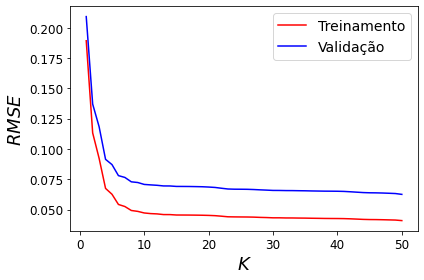

In [68]:
# gráfico do RMSE para cada K nos conjuntos de treinamento e validação
plt.plot(np.arange(1,K_max+1,1), rmse_matrix_train, "r-", label = "Treinamento")
plt.plot(np.arange(1,K_max+1,1), rmse_matrix, "b-", label = "Validação")
plt.xlabel("$K$", fontsize=18)
plt.ylabel("$RMSE$", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=14)
save_fig("validation")
plt.show()

In [69]:
print(rmse_matrix[45:])
rmse_min = min(rmse_matrix)
rmse_min_index = np.where(rmse_matrix == rmse_min)
print(rmse_min_index)

# melhor K: 50

[0.0637744  0.06364101 0.06344428 0.0632158  0.06252773]
(array([49], dtype=int64),)


Saving figure teste


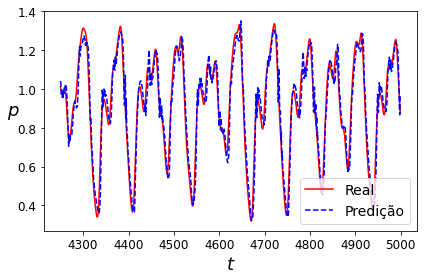

In [72]:
# Estimativa com K=50 (erro mínimo) para conjunto de teste 
t_y, x, y = monta_matrizes(train_set, K=50)
lin_reg.fit(x, y) # fit com matrizes de treinamento
t_test, x_test, y_test = new_matrices(50, test_set) 
y_predict = lin_reg.predict(x_test) # estima valores do conjunto de teste com coeficientes obtidos no treinamento

# gráfico com amostras de teste e estimativas com K = 50 (erro mínimo)
plt.plot(t_test, y_test, "r-", label = "Real")
plt.plot(t_test, y_predict, "b--", label = "Predição")
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$p$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.legend(loc="best", fontsize=14)
save_fig("teste")
plt.show()

# Segunda Parte

In [53]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "segunda_parte"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)